In [ ]:
import pandas as pd

df = pd.read_csv('spy5m.csv')
df.rename(columns={'t': 'timestamp', 'v': 'volume', 'vw': 'vwap', 'o': 'open', 'c': 'close', 'h': 'high', 'l': 'low', 't.1': 'timestamp_unix', 'n': 'transactions'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize('America/New_York')
df.drop(columns=['timestamp_unix'], inplace=True)
df.set_index('timestamp', inplace=True)

# create a column of labels based on whether or not the next row goes up or down
df['label'] = (df['close'].shift(-1) > df['close']).astype(int)

import pickle
with open('spy5m.pkl', 'wb') as f:
    pickle.dump(df, f)


In [ ]:
import pickle
with open('spy5m.pkl', 'wb') as f:
    pickle.dump(df, f)

In [1]:
import pickle
import pandas as pd 

with open('spy5m.pkl', 'rb') as f:
    df = pickle.load(f)
df

,volume,vwap,open,close,high,low,transactions
timestamp,,,,,,,
2003-09-10 08:00:00-04:00,1000.0,102.8600,102.8600,102.8600,102.8600,102.86,1
2003-09-10 08:05:00-04:00,1600.0,102.8750,102.8600,102.9000,102.9000,102.86,4
2003-09-10 08:10:00-04:00,1300.0,102.8615,102.9000,102.8500,102.9000,102.85,2
2003-09-10 08:20:00-04:00,100.0,102.8000,102.8000,102.8000,102.8000,102.80,1
2003-09-10 08:25:00-04:00,17900.0,102.7358,102.7200,102.7300,102.7700,102.72,5
...,...,...,...,...,...,...,...
2024-04-30 19:40:00-04:00,10401.0,500.9938,500.9101,501.0682,501.0682,500.91,93
2024-04-30 19:45:00-04:00,3686.0,501.1517,501.1200,501.1500,501.1800,501.11,62
2024-04-30 19:50:00-04:00,1952.0,501.0709,501.1500,500.9900,501.1500,500.99,56


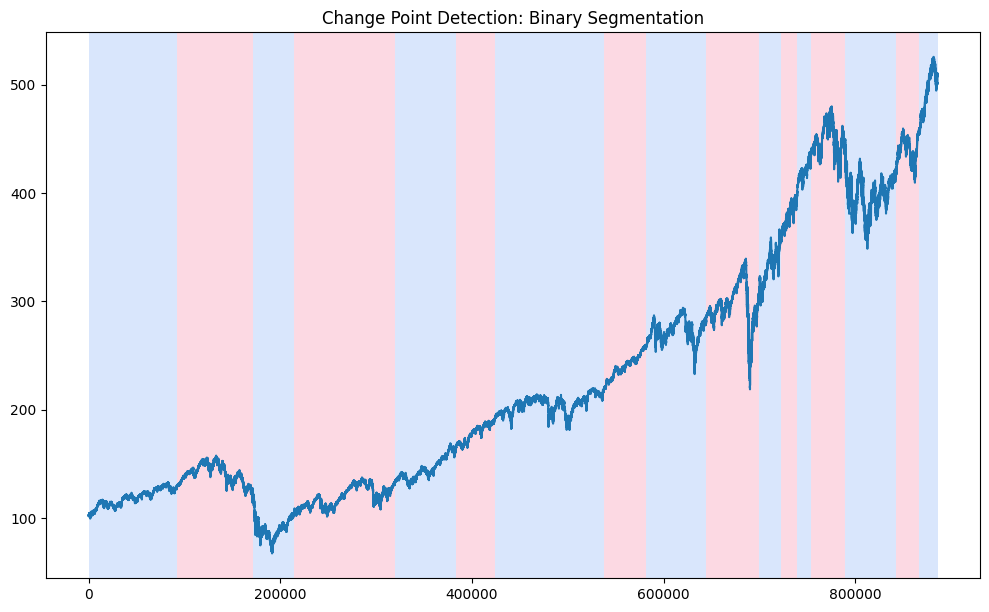

In [14]:
import ruptures as rpt
import matplotlib.pyplot as plt

# detection
algo = rpt.Binseg(model="l2").fit(df['close'].values)
result = algo.predict(n_bkps=16)

# display
rpt.display(df['close'].values, result, figsize=(10, 6))
plt.title('Change Point Detection: Binary Segmentation')
plt.show()

In [5]:
import ruptures as rpt
# detection
algo = rpt.Pelt(model="l2").fit(df['close'].values)
result = algo.predict(pen=1)

# display
rpt.display(df['close'].values, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()

: 

In [3]:
def cusum_events(df: pd.DataFrame,
                 h: float=None,
                 span: int=100,
                 devs: float=2.5) -> pd.DataFrame:
    '''
    Compute CUSUM events for a given price series.
    Args:
    df (pd.DataFrame): Dataframe with price time series
    in a single column.
    h (float): Arbitrary cumulative returns value limit to trigger
    the CUSUM filter.
    The filter is symmetric.
    If h is None exponentially weighted standard deviation will
    be used.
    span (int): Span for exponential weighting of standard deviation.
    devs (float): Standard deviations to compute variable
    trigger limits if h is not defined.
    Returns:
    pd.DataFrame: Dataframe containing differentiated series.
    '''
    # Events e:
    e = pd.DataFrame(0, index=df.index,
                     columns=['CUSUM_Event'])
    s_pos = 0
    s_neg = 0
    r = df.pct_change()

    for idx in r.index:
        if h is None:
            h_ = r[:idx].ewm(span=span).std().values[-1][0]*devs
        else: h_ = h
        s_pos = max(0, s_pos+r.loc[idx].values)
        s_neg = min(0, s_neg+r.loc[idx].values)
        if s_neg < -h_:
            s_neg = 0
            e.loc[idx] = -1
        elif s_pos > h_:
            s_pos = 0
            e.loc[idx] = 1
    return e

In [ ]:
results = cusum_events(df[['close']],devs=100)
results

In [ ]:
import pickle
with open('spy5m.pkl', 'wb') as f:
    pickle.dump(df, f)

# PZ Algorithm for detecting regimes

In [2]:

def get_local_extrema(series, extrema):
    '''
    Get local maxima or minima of a series.
    A maxima or peak is defined as a point where the current value is greater than the values directly preceding and succeeding it.
    In the case of consecutive equal values, the current value is compared to the last or next different value.
    i.e. if today's price is greater than yesterday's and tomorrow's price, then today is a peak.
    similarly, if today's price is less than yesterday's and tomorrow's price, then today is a trough.
    series: pd.Series with datetime index
    extrema: 'max' or 'min'
    returns: pd.Series with datetime index
    '''
    # these first lines cover local maxima or minima where there are no back to back equal prices
    if extrema=='max':
        subset = series[(series.shift(1) < series) & (series.shift(-1) < series)] # shift 1 is prior shift -1 is next
    elif extrema=='min':
        subset = series[(series.shift(1) > series) & (series.shift(-1) > series)]

    # we iterate to find local maxima and minima where there are back to back equal values
    # i.e. "When two or more daily closing prices in a row are equal, 
    # the last of them is compared with the prices directly preceding and succeeding the string of equal prices."
    for i, current in enumerate(series):
        if i == 0:
            continue
        if i == len(series) - 1:
            continue

        if series.iloc[i-1] != current and series.iloc[i+1] != current:
            continue

        prior = series.iloc[i-1]
        next = series.iloc[i+1]
        step = 1
        while prior == current:
            step += 1
            prior = series.iloc[i-step]
        step = 1
        while next == current:
            step += 1
            next = series.iloc[i+step]
        
        if extrema=='max':
            if prior < current > next:
                subset = pd.concat([subset,pd.Series(current, index=[series.index[i]])])
        elif extrema=='min':
            if prior > current < next:
                subset = pd.concat([subset,pd.Series(current, index=[series.index[i]])])
            
    subset.sort_index(inplace=True)
    return subset


In [3]:

def drop_consecutive_extrema(peaks, troughs):
    '''
    Checks for consecutive peaks with no troughs between them, and removes the lower one.
    Similarly for consecutive troughs with no peaks between them and removes the higher one.
    peaks: pd.Series with datetime index
    troughs: pd.Series with datetime index
    returns: Tuple[pd.Series, pd.Series]; peaks, troughs
    '''
    peaks_df = pd.DataFrame(peaks, columns=['price'])
    peaks_df['extrema'] = 'max'
    troughs_df = pd.DataFrame(troughs, columns=['price'])
    troughs_df['extrema'] = 'min'
    extrema_df = pd.concat([peaks_df, troughs_df])
    extrema_df.sort_index(inplace=True)

    # check for consecutive peaks with no troughs between them, and remove the lower one
    peaks_todrop = []
    troughs_todrop = []
    for i, row in extrema_df.iterrows():
        if i == extrema_df.index[0]:
            last_row = row
            continue
        if row['extrema'] == 'max' and last_row['extrema'] == 'max':
            if row['price'] < last_row['price']:
                peaks_todrop.append(i)
            else:
                peaks_todrop.append(last_row.name)
        elif row['extrema'] == 'min' and last_row['extrema'] == 'min':
            if row['price'] > last_row['price']:
                troughs_todrop.append(i)
            else:
                troughs_todrop.append(last_row.name)
        last_row = row

    peaks = peaks.drop(peaks_todrop)
    troughs = troughs.drop(troughs_todrop)
    return peaks, troughs

In [4]:
def pz_algorithm(series, iterations=3):
    '''
    Find peaks and troughs using the PZ algorithm.
    series: pd.Series with datetime index
    returns: Tuple[pd.Series, pd.Series]; peaks, troughs
    '''
    # define the initial set of peaks and troughs
    peaks = get_local_extrema(series, 'max')
    troughs = get_local_extrema(series, 'min')

    # repeat for the number of specified iterations
    for i in range(iterations):
        peaks = get_local_extrema(peaks, 'max')
        troughs = get_local_extrema(troughs, 'min')
        # check for consecutive peaks with no troughs between them, and remove the lower one
        peaks, troughs = drop_consecutive_extrema(peaks, troughs)
    return peaks, troughs

In [5]:
peaks, troughs = pz_algorithm(df['close'], iterations=6)
print(f'Peaks: {len(peaks)}, Troughs: {len(troughs)}')

Peaks: 8, Troughs: 8


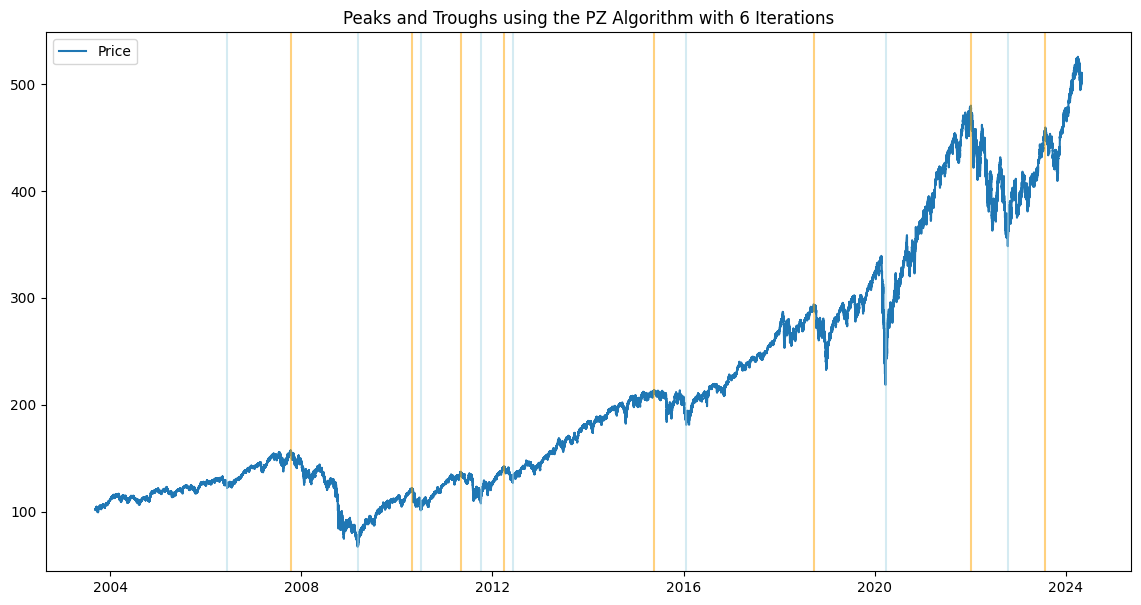

In [6]:
# plot the peaks and troughs
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(df['close'], label='Price')
# use orange vertical lines for peaks and light blue vertical lines for troughs
for peak in peaks.index:
    plt.axvline(peak, color='orange', alpha=0.5)
for trough in troughs.index:
    plt.axvline(trough, color='lightblue', alpha=0.5)
plt.title('Peaks and Troughs using the PZ Algorithm with 6 Iterations')
plt.legend()
plt.show()


In [34]:
markers = pd.concat([peaks, troughs]).sort_index()
for i,ts in enumerate(markers.index):
    if i == 0:
        df.loc[:ts,'episode'] = i
    elif i == len(markers)-1:
        df.loc[ts:,'episode'] = i
    else:
        df.loc[markers.index[i-1]:ts,'episode'] = i
df.episode = df.episode.astype(pd.Int64Dtype())
df

,volume,vwap,open,close,high,low,transactions,episode,label
timestamp,,,,,,,,,
2003-09-10 08:00:00-04:00,1000.0,102.8600,102.8600,102.8600,102.8600,102.86,1,0,1
2003-09-10 08:05:00-04:00,1600.0,102.8750,102.8600,102.9000,102.9000,102.86,4,0,0
2003-09-10 08:10:00-04:00,1300.0,102.8615,102.9000,102.8500,102.9000,102.85,2,0,0
2003-09-10 08:20:00-04:00,100.0,102.8000,102.8000,102.8000,102.8000,102.80,1,0,0
2003-09-10 08:25:00-04:00,17900.0,102.7358,102.7200,102.7300,102.7700,102.72,5,0,0
...,...,...,...,...,...,...,...,...,...
2024-04-30 19:40:00-04:00,10401.0,500.9938,500.9101,501.0682,501.0682,500.91,93,15,1
2024-04-30 19:45:00-04:00,3686.0,501.1517,501.1200,501.1500,501.1800,501.11,62,15,0
2024-04-30 19:50:00-04:00,1952.0,501.0709,501.1500,500.9900,501.1500,500.99,56,15,1


# Labelling

In [36]:
# triple barrier labelling would be the most realistic setup
# but will start with the simplest setup which is just up/down on the next close price

df['label'] = (df['close'].shift(-1) > df['close']).astype(int)
df

,volume,vwap,open,close,high,low,transactions,episode,label
timestamp,,,,,,,,,
2003-09-10 08:00:00-04:00,1000.0,102.8600,102.8600,102.8600,102.8600,102.86,1,0,1
2003-09-10 08:05:00-04:00,1600.0,102.8750,102.8600,102.9000,102.9000,102.86,4,0,0
2003-09-10 08:10:00-04:00,1300.0,102.8615,102.9000,102.8500,102.9000,102.85,2,0,0
2003-09-10 08:20:00-04:00,100.0,102.8000,102.8000,102.8000,102.8000,102.80,1,0,0
2003-09-10 08:25:00-04:00,17900.0,102.7358,102.7200,102.7300,102.7700,102.72,5,0,0
...,...,...,...,...,...,...,...,...,...
2024-04-30 19:40:00-04:00,10401.0,500.9938,500.9101,501.0682,501.0682,500.91,93,15,1
2024-04-30 19:45:00-04:00,3686.0,501.1517,501.1200,501.1500,501.1800,501.11,62,15,0
2024-04-30 19:50:00-04:00,1952.0,501.0709,501.1500,500.9900,501.1500,500.99,56,15,1


In [37]:
import pickle
with open('spy5m_labelled_episodes.pkl', 'wb') as f:
    pickle.dump(df, f)